<a href="https://colab.research.google.com/github/wiltacca/Portfolio/blob/main/Image_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the Required Packages

from tensorflow import keras
print('keras: ', keras.__version__)

import tensorflow as tf
# with tf.device('/device:GPU:0') ---> train model fit with GPU

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

keras:  2.4.0


In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Step 1: Data Loading

In [ ]:
# Defining locating images as the size is too huge and unable to upload in GitHub!
base_dir = 'C:/Users/wilt7/Jypyter/NP Deep Learning/Assignment1/food'

train_dir = os.path.join(base_dir, 'train') # training
validation_dir = os.path.join(base_dir, 'validation') # validation 
test_dir = os.path.join(base_dir, 'test') # testing


# Defining the following as:

# Resize all the images as 150*150 pixels
img_size = 150 # 150 pixels X 150 pixels by arbitrary choice

# Epochs size
epochs_size = 50

# Training, validation and testing sample size
train_sample_size = 7500
validation_sample_size = 2000
test_sample_size = 500

# Training and validation batch size
train_batch_size = 20
validation_batch_size = 20
test_batch_size = 20

##### Data preprocessing

As you already know by now, data should be formatted into appropriately **pre-processed floating point tensors before being fed into our 
network**. 

Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) # training 
test_datagen = ImageDataGenerator(rescale=1./255) # testing 

train_generator = train_datagen.flow_from_directory(
        # This is the training directory
        train_dir,
        # All images will be resized to 150x150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=train_batch_size, # training batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( # Note named test_datagen but it is a validation data!
        # This is the validation directory
        validation_dir,
        # All images will be resized to 150x150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=validation_batch_size, # validation batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


## Step 2:  Develop the Image Classification Models

### # Model 1: Baseline 6 Layers Convnets Without Data Augmentation 

In [ ]:
# Build the Model

# Let build a 6 layers convnet as a baseline model 
model1 = models.Sequential()
model1.add(layers.Conv2D(100, (3, 3), activation='relu', input_shape=(img_size, img_size, 3))) # 150 pixels, 150 pixels, 3 Channels
model1.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model1.add(layers.Conv2D(50, (3, 3), activation='relu')) # 50 filters, each filter size is 3 by 3, size of input is 13 by 13, perform ReLU
model1.add(layers.Flatten()) # Lay out the 50 layers of size 72 by 72 into a single tensor of size 259200
model1.add(layers.Dense(512, activation='relu')) #  1 Hidden layer with 512 dense layer units also determine number of output from the layer
model1.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 50)        45050     
_________________________________________________________________
flatten (Flatten)            (None, 259200)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               132710912 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 132,763,892
Trainable params: 132,763,892
Non-trainable params: 0
__________________________________________

For our compilation step, we'll go with the RMSprop optimizer as usual. Since we ended our network with multiclass, single unit, we will use categorical_crossentropy as our loss.

In [ ]:
model1.compile(loss='categorical_crossentropy', # Multiclass, single label classification 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Learning rate = 0.0001
              metrics=['acc']) # Accuracy for classification 

Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) [3 is the channels](x) and binary labels (shape `(20, 10)`). 20 is the number of samples (images) in each batch (the batch size of 20) and 10 is the 10 neurons/units (10-way classification). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder, so we need to `break` the iteration loop at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break # to stop train_generator at some point

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 10)


Let's `fit` our model to the data.The first argument can be a Python generator that will yield batches of inputs and targets [indefinitely](x). 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20 samples, so it will take 375 batches (7500/20) until we see our target of 7,500 (20*375) samples.

Similarly when we pass a generator to `validation_data` argument, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history1 = model1.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 7,500/train_batch_size: 20 (20 * 375 = 7,500)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size /validation_batch_size) # validation_sample_size: 2,000/validation_batch_size: 20  (20 * 100 = 1,000)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - 444s 1s/step - loss: 2.0077 - acc: 0.3129 - val_loss: 1.8670 - val_acc: 0.3530
Epoch 2/50
375/375 [==============================] - 439s 1s/step - loss: 1.5015 - acc: 0.4965 - val_loss: 1.7363 - val_acc: 0.4005
Epoch 3/50
375/375 [==============================] - 440s 1s/step - loss: 1.1174 - acc: 0.6375 - val_loss: 1.7231 - val_acc: 0.4130
Epoch 4/50
375/375 [==============================] - 440s 1s/step - loss: 0.7468 - acc: 0.7700 - val_loss: 1.9056 - val_acc: 0.4100
Epoch 5/50
375/375 [==============================] - 442s 1s/step - loss: 0.4455 - acc: 0.8769 - val_loss: 2.1127 - val_acc: 0.4110
Epoch 6/50
375/375 [==============================] - 440s 1s/step - loss: 0.2327 - acc: 0.9439 - val_loss: 2.3108 - val_acc: 0.4100
Epoch 7/50
375/375 [==============================] - 441s 1s/step - loss: 0.1116 - acc: 0.9765 - val_loss: 2.7543 - val_acc: 0.4115
Epoch 8/50
375/375 [==============================] - 440s 1s/step - 

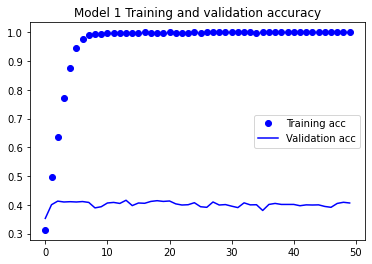

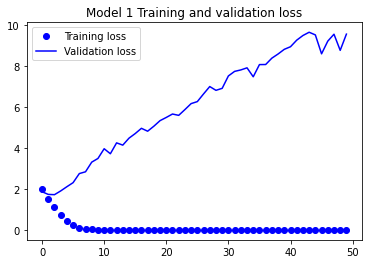

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 1 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 1 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model1.save('food_model_1.h5')

### # Model 2: 14 Layers Convnets & Performed Regularization Without Data Augmentation

In [ ]:
# Build the Model

# 14 layers convnets 
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3))) # 150 pixels, 150 pixels, 3 Channels
model2.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model2.add(layers.Flatten()) # Lay out the 128 layers of size 7 by 7 into a single tensor of size 6272
model2.add(layers.Dense(512, activation='relu')) # 1st Hidden layer 512 Dense layer units also determine number of output from the layer
model2.add(layers.Dropout(0.5)) # dropout for regularization 
model2.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01),activation='relu')) # 2nd Hidden layer 256 Dense layer units, L2 regularization, perform ReLU
model2.add(layers.Dropout(0.5)) # dropout for regularization 
model2.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)      

For our compilation step, we'll go with the RMSprop optimizer as usual. Since we ended our network with multiclass, single unit, we will use categorical_crossentropy as our loss.

In [ ]:
model2.compile(loss='categorical_crossentropy', # Multiclass, single label classification 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Learning rate = 0.0001
              metrics=['acc']) # Accuracy for classification 

Let's `fit` our model to the data.The first argument can be a Python generator that will yield batches of inputs and targets [indefinitely](x). 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20 samples, so it will take 375 (7500/20) batches until we see our target of 7,500 (20*375) samples.

Similarly when we pass a generator to `validation_data` argument, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

Let's train our network using regularization L2 and dropout:

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history2 = model2.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 7,500/train_batch_size: 20 (20 * 375 = 7,500)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size) # validation_sample_size: 2,000/validation_batch_size: 20  (20 * 100 = 1,000)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - 116s 309ms/step - loss: 4.3259 - acc: 0.1879 - val_loss: 3.3832 - val_acc: 0.2830
Epoch 2/50
375/375 [==============================] - 116s 310ms/step - loss: 3.0488 - acc: 0.2979 - val_loss: 2.8145 - val_acc: 0.3170
Epoch 3/50
375/375 [==============================] - 116s 309ms/step - loss: 2.6298 - acc: 0.3492 - val_loss: 2.4880 - val_acc: 0.3735
Epoch 4/50
375/375 [==============================] - 116s 310ms/step - loss: 2.3928 - acc: 0.3789 - val_loss: 2.3993 - val_acc: 0.3680
Epoch 5/50
375/375 [==============================] - 116s 309ms/step - loss: 2.2086 - acc: 0.4065 - val_loss: 2.1879 - val_acc: 0.4055
Epoch 6/50
375/375 [==============================] - 116s 310ms/step - loss: 2.0470 - acc: 0.4361 - val_loss: 2.0883 - val_acc: 0.4210
Epoch 7/50
375/375 [==============================] - 117s 311ms/step - loss: 1.9275 - acc: 0.4599 - val_loss: 1.9524 - val_acc: 0.4430
Epoch 8/50
375/375 [============================

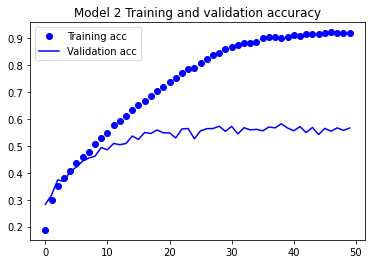

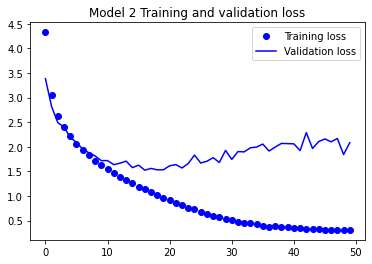

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 2 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 2 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model2.save('food_model_2.h5')

### # Model 3: 14 Layers Convnets & Performed Regularization With Data Augmentation

In [ ]:
# Build the Model

# 14 layers convnets 
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3))) # 150 pixels, 150 pixels, 3 Channels
model3.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2))) # Max pooling on size 2 by 2
model3.add(layers.Flatten()) # Lay out the 128 layers of size 7 by 7 into a single tensor of size 6272
model3.add(layers.Dense(512, activation='relu')) # 1st Hidden layer 512 Dense layer units also determine number of output from the layer
model3.add(layers.Dropout(0.5)) # dropout for regularization 
model3.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01),activation='relu')) # 2nd Hidden layer 256 Dense layer units, L2 regularization, perform ReLU
model3.add(layers.Dropout(0.5)) # dropout for regularization 
model3.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

For our compilation step, we'll go with the RMSprop optimizer as usual. Since we ended our network with multiclass, single unit, we will use categorical_crossentropy as our loss.

In [ ]:
model3.compile(loss='categorical_crossentropy', # Multiclass, single label classification 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Learning rte = 0.0001
              metrics=['acc']) # Accuracy for classification 

In [ ]:
# All images will be rescaled by 1./255 to become 0 to 1
train_datagen = ImageDataGenerator( # training only!
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# All images will be rescaled by 1./255 to become 0 to 1
# Note that the validation data should not be augmented!!!!
test_datagen = ImageDataGenerator(rescale=1./255) # testing 

train_generator = train_datagen.flow_from_directory(
        # This is the training directory
        train_dir,
        # All images will be resized to 150 pixel X 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=train_batch_size, # training batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( # Note named test_datagen but it is a validation data!
        # This is the validation directory
        validation_dir,
        # All images will be resized to 150 pixel X 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=validation_batch_size, # testing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Let's `fit` our model to the data.The first argument can be a Python generator that will yield batches of inputs and targets [indefinitely](x). 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20 samples, so it will take 375 batches (7500/20) until we see our target of 7,500 (20*375) samples.

Similarly when we pass a generator to `validation_data` argument, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

Let's train our network using data augmentation, regularization L2 and dropout:

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history3 = model3.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 7,500/train_batch_size: 20 (20 * 375 = 7,500)
        epochs=100, # Change to 100 instead of 50
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size) # validation_sample_size: 2,000/validation_batch_size: 20  (20 * 100 = 1,000)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/100
375/375 [==============================] - 129s 344ms/step - loss: 4.3191 - acc: 0.1620 - val_loss: 3.3391 - val_acc: 0.2515
Epoch 2/100
375/375 [==============================] - 129s 343ms/step - loss: 3.0359 - acc: 0.2220 - val_loss: 2.7284 - val_acc: 0.2875
Epoch 3/100
375/375 [==============================] - 129s 345ms/step - loss: 2.6383 - acc: 0.2647 - val_loss: 2.6220 - val_acc: 0.2605
Epoch 4/100
375/375 [==============================] - 129s 344ms/step - loss: 2.4330 - acc: 0.3012 - val_loss: 2.3896 - val_acc: 0.2960
Epoch 5/100
375/375 [==============================] - 129s 344ms/step - loss: 2.2965 - acc: 0.3263 - val_loss: 2.2539 - val_acc: 0.3260
Epoch 6/100
375/375 [==============================] - 129s 344ms/step - loss: 2.1876 - acc: 0.3323 - val_loss: 2.2884 - val_acc: 0.3160
Epoch 7/100
375/375 [==============================] - 129s 344ms/step - loss: 2.0958 - acc: 0.3572 - val_loss: 2.0660 - val_acc: 0.3715
Epoch 8/100
375/375 [====================

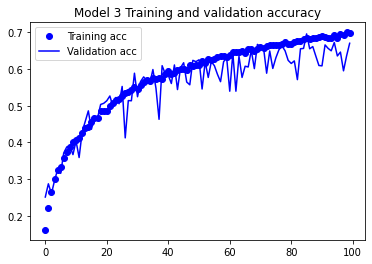

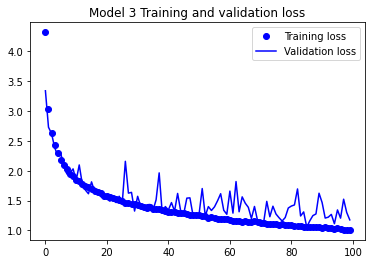

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 3 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 3 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model3.save('food_model_3.h5')

### # Model 4: Utilizing Pre-Trained Model For Features Extraction Without Data Augmentation

**Feature extraction** consists of using the representations [learned by a previous network](x) to extract interesting features from new samples. These features are then run through a new classifier, which is [trained from scratch](x).

In our case, we use the convolutional base of the **VGG16 network, trained on ImageNet**, to extract interesting features from 
our food images, and then training multi-classifier on top of these features.

**The VGG16 model, among others, comes pre-packaged with Keras**. You can import it from the `tensorflow.keras.applications` module.

In [ ]:
# Defining VGG convolutional neural net
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3)) # 150 pixels, 150 pixels, 3 Channels

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only 10 classes, baby back ribs, bibimbap, cupcakes, dumplings, fried calamari. garlic bread, lasagna, pancakes, prime rib, and tiramisu), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the **feature on top of which we will stick a densely-connected classifier**.

At this point, we could proceed: 

[Feature extraction without data augmentation:](x)
**Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier.** This solution is very fast and cheap to run, because it **only requires running the convolutional base once for every input image**, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

We will record the output of `conv_base` on our data and using these outputs as inputs to a **new model**.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will **extract features from these images** simply by calling the `predict` method of the `conv_base` model.

In [ ]:
# All images will be rescaled by 1./255 to become 0 to 1
datagen = ImageDataGenerator(rescale=1./255) # rescaling 

batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 4 pixels, 4 pixels, 512 filters 
    labels = np.zeros(shape=(sample_count, 10)) # Change this part!
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical') # Since we use categorical_crossentropy loss, we need categorical labels
    i = 0
    for inputs_batch, labels_batch in generator:
        # extract features from the images by calling the predict method of the conv_base model
        features_batch = conv_base.predict(inputs_batch) # to get the final part after cutting off FC classifier 
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

# Features extraction processes
train_features, train_labels = extract_features(train_dir, 7500) # 7500 training images
validation_features, validation_labels = extract_features(validation_dir, 2000) # 2000 validation images 
test_features, test_labels = extract_features(test_dir, 500) # 500 tesing images

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
print(train_features.shape)
print(train_labels.shape)

(7500, 4, 4, 512)
(7500, 10)


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will **feed them to a [densely-connected classifier](x), so first we must 
flatten them to `(samples, 4 * 4 * 512)`:**

In [ ]:
# Manual flattening process
train_features = np.reshape(train_features, (7500, 4 * 4 * 512)) # 7500 training images
validation_features = np.reshape(validation_features, (2000, 4 * 4 * 512))  # 2000 validation images 
test_features = np.reshape(test_features, (500, 4 * 4 * 512)) # 500 testing images

At this point, we can define our [densely-connected classifier](x) **(note the use of dropout for regularization)**, and train it on the data and 
labels that we just recorded:

In [ ]:
model4 = models.Sequential()
model4.add(layers.Dense(256, activation='relu', input_shape=(4 * 4 * 512,))) # 4 pixels, 4 pixels, 512 filters
model4.add(layers.Dropout(0.5)) # dropout for regularization 
model4.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 2,099,978
Trainable params: 2,099,978
Non-trainable params: 0
_________________________________________________________________


For our compilation step, we'll go with the RMSprop optimizer as usual. Since we ended our network with multiclass, single unit, we will use categorical_crossentropy as our loss.

In [ ]:
model4.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), # Learning rate = 0.00002
              loss='categorical_crossentropy', # Multiclass, single label classification 
              metrics=['acc'])  # Accuracy for classification 

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history4 = model4.fit(train_features, train_labels,
                          epochs=epochs_size,
                          batch_size=epochs_size,
                          validation_data=(validation_features, validation_labels))
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
150/150 [==============================] - 3s 18ms/step - loss: 2.2443 - acc: 0.2052 - val_loss: 1.9024 - val_acc: 0.4265
Epoch 2/50
150/150 [==============================] - 3s 17ms/step - loss: 1.8180 - acc: 0.3956 - val_loss: 1.6525 - val_acc: 0.5070
Epoch 3/50
150/150 [==============================] - 3s 17ms/step - loss: 1.6021 - acc: 0.4795 - val_loss: 1.4907 - val_acc: 0.5555
Epoch 4/50
150/150 [==============================] - 3s 17ms/step - loss: 1.4445 - acc: 0.5256 - val_loss: 1.3863 - val_acc: 0.5830
Epoch 5/50
150/150 [==============================] - 3s 17ms/step - loss: 1.3437 - acc: 0.5660 - val_loss: 1.3145 - val_acc: 0.6045
Epoch 6/50
150/150 [==============================] - 3s 17ms/step - loss: 1.2604 - acc: 0.5953 - val_loss: 1.2658 - val_acc: 0.6175
Epoch 7/50
150/150 [==============================] - 3s 17ms/step - loss: 1.1930 - acc: 0.6184 - val_loss: 1.2199 - val_acc: 0.6235
Epoch 8/50
150/150 [==============================] - 3s 17ms/step - 

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than 4 second even on CPU.

Let's take a look at the loss and accuracy curves during training:

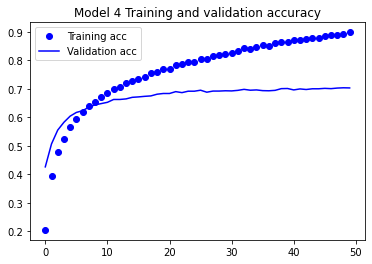

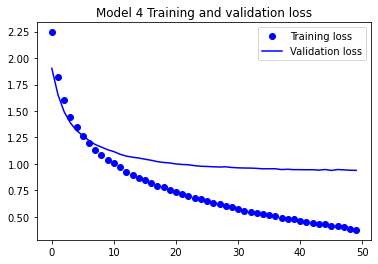

In [ ]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 4 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 4 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evalute the accuarcy & loss before saving and loading the model

train_loss, train_acc = model4.evaluate(train_features, train_labels)
validation_loss, validation_acc = model4.evaluate(validation_features, validation_labels) 
test_loss, test_acc = model4.evaluate(test_features, test_labels) 

16/16 [==============================] - 0s 3ms/step - loss: 0.8775 - acc: 0.7180


In [ ]:
# Save the Model
model4.save('food_model_4.h5')

### # Model 5: Utilizing Pre-Trained Model For Features Extraction With Data Augmentation

At this point, there are two ways we could proceed: 

[Feature extraction with data augmentation:](x)
**Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.** However, for this same reason, this technique is far more expensive than the first one.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to **leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the input**. Note that this technique is very computationally expensive and the below program may take very long time to complete.

Because models behave just like layers, you can **add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer**. 
So you can do the following:


In [ ]:
model5 = models.Sequential()
# adding the conv_base to our sequential model
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

This is what our model looks like now:

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 16,814,666
Non-trainable params: 0
_________________________________________________________________


As you can see, the [convolutional base of VGG16 has 14,714,688 parameters](x), which is very large. The [classifier we are adding on top has 2 
million parameters](x).

Before we compile and train our model, a very important thing to do is to **freeze the convolutional base. "[Freezing](x)" a layer or set of 
layers means [preventing their weights from getting updated during training](x). If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, [effectively destroying the representations previously learned](x).**

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [ ]:
conv_base.trainable = False # freezing a network

def print_layer_trainable():
    for layer in conv_base.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


**With this setup, only the weights from the two `Dense` layers that we added will be trained!** [Note that in order for these changes to take effect, we must first compile the model.](x) If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
# Use ImageDataGenerator to do Data preprocessing and Data Augmentation
train_datagen = ImageDataGenerator( # training only 
      # All images will be rescaled by 1./255 to become 0 to 1
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# All images will be rescaled by 1./255 to become 0 to 1
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255) # testing 

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=train_batch_size, # training batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size),  # resize images
        batch_size=validation_batch_size, # validation batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
model5.compile(loss='categorical_crossentropy', # Multiclass, single label classification
              optimizer=optimizers.RMSprop(learning_rate=2e-5), # Learning rate = 0.00002
              metrics=['acc']) # Accuracy for classification

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history5 = model5.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 2,000/train_batch_size: 20 (20 * 100 = 2,000)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size, # validation_sample_size: 1,000/validation_batch_size: 20 (20 * 50 = 1,000)
        verbose=1)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - 522s 1s/step - loss: 1.9809 - acc: 0.3312 - val_loss: 1.6463 - val_acc: 0.4685
Epoch 2/50
375/375 [==============================] - 521s 1s/step - loss: 1.5658 - acc: 0.4960 - val_loss: 1.4081 - val_acc: 0.5530
Epoch 3/50
375/375 [==============================] - 521s 1s/step - loss: 1.3963 - acc: 0.5477 - val_loss: 1.2782 - val_acc: 0.5860
Epoch 4/50
375/375 [==============================] - 520s 1s/step - loss: 1.2935 - acc: 0.5779 - val_loss: 1.1891 - val_acc: 0.6155
Epoch 5/50
375/375 [==============================] - 520s 1s/step - loss: 1.2289 - acc: 0.6013 - val_loss: 1.1649 - val_acc: 0.6195
Epoch 6/50
375/375 [==============================] - 521s 1s/step - loss: 1.1801 - acc: 0.6149 - val_loss: 1.1296 - val_acc: 0.6335
Epoch 7/50
375/375 [==============================] - 521s 1s/step - loss: 1.1390 - acc: 0.6276 - val_loss: 1.1192 - val_acc: 0.6315
Epoch 8/50
375/375 [==============================] - 525s 1s/step - 

Let's take a look at the loss and accuracy curves during training:

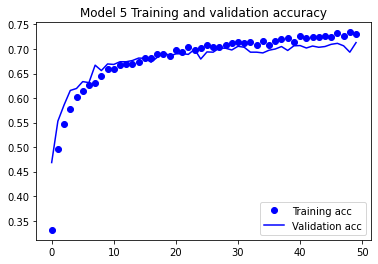

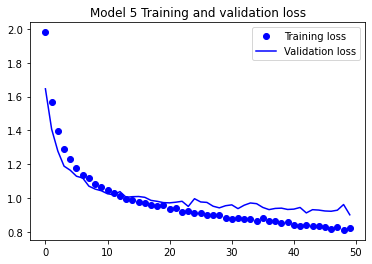

In [ ]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 5 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 5 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model5.save('food_model_5.h5')

### # Model 5A: Utilizing Pre-Trained Model For Features Extraction With Data Augmentation + Callback Method

In [ ]:
model5.compile(loss='categorical_crossentropy', # Multiclass, single label classification
              optimizer=optimizers.RMSprop(learning_rate=2e-5), # Learning rate = 0.00002
              metrics=['acc']) # Accuracy for classification

In [ ]:
# model_checkpoint_callback method 

from keras.callbacks import ModelCheckpoint

filepath = 'best_food_model5A.hdf5'

checkpoint5A = ModelCheckpoint(filepath=filepath, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint5A]

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history5A = model5.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 2,000/train_batch_size: 20 (20 * 100 = 2,000)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size, # validation_sample_size: 1,000/validation_batch_size: 20 (20 * 50 = 1,000)
        callbacks=[callbacks], # model_checkpoint_callback
        verbose=1)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.8192 - acc: 0.7279
Epoch 00001: val_acc improved from -inf to 0.70850, saving model to best_food_model5A.hdf5
375/375 [==============================] - 514s 1s/step - loss: 0.8192 - acc: 0.7279 - val_loss: 0.9261 - val_acc: 0.7085
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.8199 - acc: 0.7289
Epoch 00002: val_acc did not improve from 0.70850
375/375 [==============================] - 512s 1s/step - loss: 0.8199 - acc: 0.7289 - val_loss: 0.9479 - val_acc: 0.6970
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 0.7875 - acc: 0.7391
Epoch 00003: val_acc did not improve from 0.70850
375/375 [==============================] - 511s 1s/step - loss: 0.7875 - acc: 0.7391 - val_loss: 0.9362 - val_acc: 0.7055
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 0.8052 - acc: 0.7337
Epoch 00004: val_acc did not improve from 0.70850
375/375 [====================

Let's take a look at the loss and accuracy curves during training:

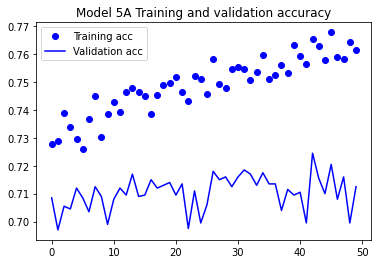

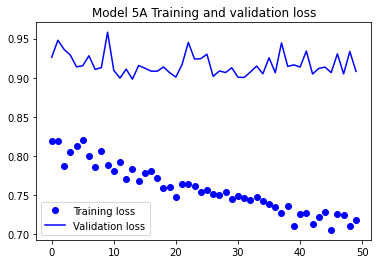

In [ ]:
acc = history5A.history['acc']
val_acc = history5A.history['val_acc']
loss = history5A.history['loss']
val_loss = history5A.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 5A Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 5A Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model5.save('food_model_5A.h5')

### # Model 6: Utilizing Pre-Trained Model For Features Extraction And Fine Tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
**Fine-tuning consists in [unfreezing](x) a few of the top layers 
of a frozen model base used for feature extraction, and [jointly training both](x) the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers.** This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [ ]:
model6 = models.Sequential()
# adding the conv_base to our sequential model
model6.add(conv_base)
model6.add(layers.Flatten())
model6.add(layers.Dense(256, activation='relu'))
model6.add(layers.Dense(10, activation='softmax')) # 1 Output layer with 10 neurons/units (10-way classification)

This is what our model looks like now:

In [ ]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


As you can see, the [convolutional base of VGG16 has 14,714,688 parameters](x), which is very large. The [classifier we are adding on top has 2 
million parameters](x).

Before we compile and train our model, a very important thing to do is to **freeze the convolutional base. "[Freezing](x)" a layer or set of 
layers means [preventing their weights from getting updated during training](x). If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, [effectively destroying the representations previously learned](x).**

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [ ]:
conv_base.trainable = False # freezing a network

def print_layer_trainable():
    for layer in conv_base.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


**With this setup, only the weights from the two `Dense` layers that we added will be trained!** [Note that in order for these changes to take effect, we must first compile the model.](x) If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
# Use ImageDataGenerator to do Data preprocessing and Data Augmentation
train_datagen = ImageDataGenerator( # training only 
      # All images will be rescaled by 1./255 to become 0 to 1
      rescale=1./255,
      rotation_range=50, # Changed
      width_shift_range=0.3, # Changed
      height_shift_range=0.3,# Changed
      shear_range=0.3, # Changed
      zoom_range=0.3, # Changed
      horizontal_flip=True,
      fill_mode='nearest')

# All images will be rescaled by 1./255 to become 0 to 1
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255) # testing 

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=train_batch_size, # training batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size),  # resize images
        batch_size=validation_batch_size, # validation batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
model6.compile(loss='categorical_crossentropy', # Multiclass, single label classification
              optimizer=optimizers.RMSprop(learning_rate=3e-5), # Learning rate = 0.00003
              metrics=['acc']) # Accuracy for classification

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history6 = model6.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 2,000/train_batch_size: 20 (20 * 100 = 2,000)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size, # validation_sample_size: 1,000/validation_batch_size: 20 (20 * 50 = 1,000)
        verbose=1)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - 511s 1s/step - loss: 1.9731 - acc: 0.3239 - val_loss: 1.6102 - val_acc: 0.4750
Epoch 2/50
375/375 [==============================] - 511s 1s/step - loss: 1.6123 - acc: 0.4652 - val_loss: 1.3741 - val_acc: 0.5480
Epoch 3/50
375/375 [==============================] - 510s 1s/step - loss: 1.4676 - acc: 0.5189 - val_loss: 1.2804 - val_acc: 0.5760
Epoch 4/50
375/375 [==============================] - 510s 1s/step - loss: 1.3846 - acc: 0.5480 - val_loss: 1.2324 - val_acc: 0.5935
Epoch 5/50
375/375 [==============================] - 510s 1s/step - loss: 1.3404 - acc: 0.5543 - val_loss: 1.1775 - val_acc: 0.6060
Epoch 6/50
375/375 [==============================] - 512s 1s/step - loss: 1.2857 - acc: 0.5721 - val_loss: 1.1729 - val_acc: 0.6110
Epoch 7/50
375/375 [==============================] - 511s 1s/step - loss: 1.2422 - acc: 0.5847 - val_loss: 1.1266 - val_acc: 0.6420
Epoch 8/50
375/375 [==============================] - 510s 1s/step - 

Let's take a look at the loss and accuracy curves during training:

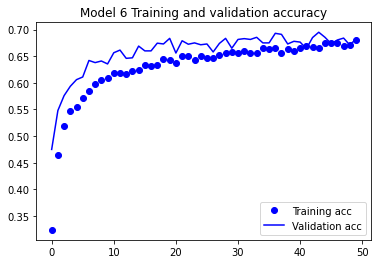

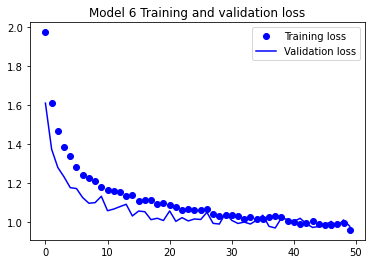

In [ ]:
acc = history6.history['acc']
val_acc = history6.history['val_acc']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 6 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 6 Training and validation loss')
plt.legend()

plt.show()

**We have stated before that it was necessary to [freeze](x) the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been [trained](x).** 

If the [classifier wasn't already trained](x), then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed.

[Thus the steps 
for fine-tuning a network are as follow:](x)

* 1) **Add your custom network on top of an [already trained base network.](x)**
* 2) **[Freeze](x) the base network.**
* 3) **[Train](x) the part you added.**
* 4) **[Unfreeze some layers](x) in the base network.**
* 5) **[Jointly train both](x) these layers and the part you added.**

We have **already completed the [first 3 steps](x) when doing feature extraction.** Let's **proceed with the [4th step](x): we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it**.

As a reminder, this is what our convolutional base looks like:

In [ ]:
conv_base.summary()
print_layer_trainable()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

**We will [fine-tune the last 3 convolutional layers](x), which means that all layers up until `block4_pool` should be [frozen](x), and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be [trainable](x).**

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. 

However, we need to consider that:

* [Earlier layers in the convolutional base encode more generic, reusable features](x), while [layers higher up encode more specialized features](x). 
It is **more useful to fine-tune the [more specialized features](x), as these are the ones that need to be repurposed on our new problem**. There would 
be fast-decreasing returns in fine-tuning lower layers.


* **The more parameters we are training, the more we are at risk of [overfitting](x)**. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. **The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers (block5_conv1 to conv3) that we are 
fine-tuning. Updates that are too large may [harm](x) these representations.**

[Now let's proceed with fine-tuning:](x)

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
                
model6.compile(loss='binary_crossentropy', # Multiclass, single label classification
              optimizer=optimizers.RMSprop(learning_rate=1e-5), # Learning rate = 0.00001
              metrics=['acc']) # Accuracy for classification

model6.summary()
print_layer_trainable()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 9,179,402
Non-trainable params: 7,635,264
_________________________________________________________________
False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
F

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history6 = model6.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 2,000/train_batch_size: 20 (20 * 100 = 2,000)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size)  # validation_sample_size: 1,000/validation_batch_size: 20 (20 * 50 = 1,000)
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - 592s 2s/step - loss: 0.9870 - acc: 0.6744 - val_loss: 0.9091 - val_acc: 0.7110
Epoch 2/50
375/375 [==============================] - 608s 2s/step - loss: 0.8974 - acc: 0.7032 - val_loss: 0.9424 - val_acc: 0.7140
Epoch 3/50
375/375 [==============================] - 607s 2s/step - loss: 0.8345 - acc: 0.7235 - val_loss: 0.8378 - val_acc: 0.7340
Epoch 4/50
375/375 [==============================] - 607s 2s/step - loss: 0.7938 - acc: 0.7369 - val_loss: 0.9254 - val_acc: 0.7210
Epoch 5/50
375/375 [==============================] - 606s 2s/step - loss: 0.7727 - acc: 0.7471 - val_loss: 0.8987 - val_acc: 0.7385
Epoch 6/50
375/375 [==============================] - 606s 2s/step - loss: 0.7295 - acc: 0.7588 - val_loss: 0.7954 - val_acc: 0.7505
Epoch 7/50
375/375 [==============================] - 606s 2s/step - loss: 0.7058 - acc: 0.7619 - val_loss: 0.8475 - val_acc: 0.7510
Epoch 8/50
375/375 [==============================] - 606s 2s/step - 

Let's take a look at the loss and accuracy curves during training:

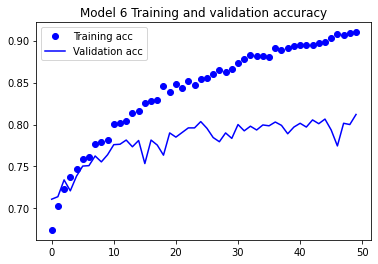

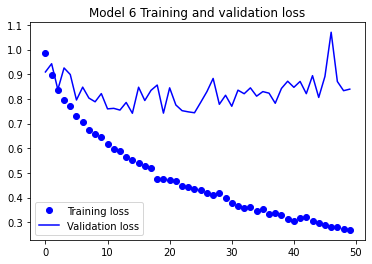

In [ ]:
acc = history6.history['acc']
val_acc = history6.history['val_acc']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 6 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 6 Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model6.save('food_model_6.h5')

### # Model 6A: Utilizing Pre-Trained Model For Features Extraction And Fine Tuning + Callback Method

In [ ]:
model6.compile(loss='categorical_crossentropy', # Multiclass, single label classification
              optimizer=optimizers.RMSprop(lr=1e-5), # Learning rate = 0.00001
              metrics=['acc']) # Accuracy for classification

In [ ]:
# Create callback method 

from keras.callbacks import ModelCheckpoint

filepath = 'best_food_model6.hdf5'

checkpoint6A = ModelCheckpoint(filepath=filepath, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint6A]

In [ ]:
# Train the Model On GPU

with tf.device('/device:GPU:0'):
    start = time.time()
    history6A = model6.fit(
        train_generator,
        steps_per_epoch=train_sample_size/train_batch_size, # train_sample_size: 2,000/train_batch_size: 20 (20 * 100 = 2,000)
        epochs=epochs_size,
        validation_data=validation_generator,
        validation_steps=validation_sample_size/validation_batch_size,  # validation_sample_size: 1,000/validation_batch_size: 20 (20 * 50 = 1,000)
        callbacks=[callbacks]) # model_checkpoint_callback
    print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.9079
Epoch 00001: val_acc improved from -inf to 0.81000, saving model to best_food_model6.hdf5
375/375 [==============================] - 585s 2s/step - loss: 0.2729 - acc: 0.9079 - val_loss: 0.8130 - val_acc: 0.8100
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 0.2623 - acc: 0.9125
Epoch 00002: val_acc did not improve from 0.81000
375/375 [==============================] - 592s 2s/step - loss: 0.2623 - acc: 0.9125 - val_loss: 0.8740 - val_acc: 0.8065
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 0.2574 - acc: 0.9137
Epoch 00003: val_acc improved from 0.81000 to 0.81650, saving model to best_food_model6.hdf5
375/375 [==============================] - 585s 2s/step - loss: 0.2574 - acc: 0.9137 - val_loss: 0.8291 - val_acc: 0.8165
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 0.2589 - acc: 0.9131
Epoch 00004: val_acc did not improve 

Epoch 32/50
375/375 [==============================] - ETA: 0s - loss: 0.1770 - acc: 0.9392
Epoch 00032: val_acc did not improve from 0.81950
375/375 [==============================] - 588s 2s/step - loss: 0.1770 - acc: 0.9392 - val_loss: 0.9695 - val_acc: 0.8080
Epoch 33/50
375/375 [==============================] - ETA: 0s - loss: 0.1785 - acc: 0.9391
Epoch 00033: val_acc did not improve from 0.81950
375/375 [==============================] - 598s 2s/step - loss: 0.1785 - acc: 0.9391 - val_loss: 1.1556 - val_acc: 0.8005
Epoch 34/50
375/375 [==============================] - ETA: 0s - loss: 0.1795 - acc: 0.9363
Epoch 00034: val_acc did not improve from 0.81950
375/375 [==============================] - 598s 2s/step - loss: 0.1795 - acc: 0.9363 - val_loss: 1.0660 - val_acc: 0.7995
Epoch 35/50
375/375 [==============================] - ETA: 0s - loss: 0.1582 - acc: 0.9459
Epoch 00035: val_acc did not improve from 0.81950
375/375 [==============================] - 598s 2s/step - loss: 0.

Let's take a look at the loss and accuracy curves during training:

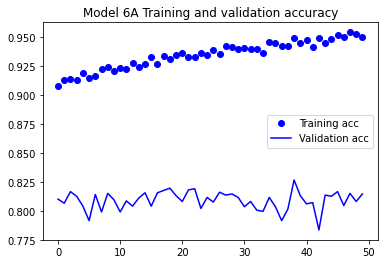

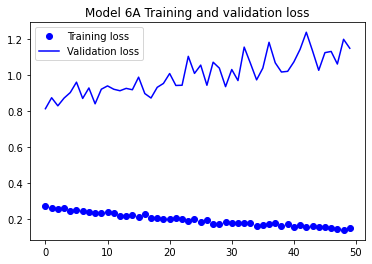

In [ ]:
acc = history6A.history['acc']
val_acc = history6A.history['val_acc']
loss = history6A.history['loss']
val_loss = history6A.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 6A Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 6A Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model6.save('food_model_6A.h5')

## Step 3 – Evaluate the Developed Models using Testing Images

###  # Model 1: Evaluation Using Testing Images - Baseline 6 Layers Convnets Without Data Augmentation

In [ ]:
# Evaluate Model 1 using testing images

model1.load_weights('food_model_1.h5')

# This is what our saved model looks like:
model1.summary()

test_datagen = ImageDataGenerator(rescale=1./255) # testing set rescaling 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 50)        45050     
_________________________________________________________________
flatten (Flatten)            (None, 259200)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               132710912 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 132,763,892
Trainable params: 132,763,892
Non-trainable params: 0
__________________________________________

In [ ]:
test_loss, test_acc = model1.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 1 test accuracy:', test_acc)

25/25 [==============================] - 4s 165ms/step - loss: 9.6597 - acc: 0.3840
Model 1 test accuracy: 0.3840000033378601


###  # Model 2: Evaluation Using Testing Images - 14 Layers Convnets & Performed Regularization Without Data Augmentation

In [ ]:
# Evaluate Model 2 using testing images

model2.load_weights('food_model_2.h5')

# This is what our saved model looks like:
model2.summary()

test_datagen = ImageDataGenerator(rescale=1./255) # testing set rescaling 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 2 test accuracy:', test_acc)

25/25 [==============================] - 2s 89ms/step - loss: 2.1121 - acc: 0.5660
Model 2 test accuracy: 0.5659999847412109


###  # Model 3: Evaluation Using Testing Images - 14 Layers Convnets & Performed Regularization With Data Augmentation

In [ ]:
# Evaluate Model 3 using testing images

model3.load_weights('food_model_3.h5')

# This is what our saved model looks like:
model3.summary()

test_datagen = ImageDataGenerator(rescale=1./255) # testing set rescaling 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
test_loss, test_acc = model3.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 3 test accuracy:', test_acc)

25/25 [==============================] - 2s 92ms/step - loss: 1.1598 - acc: 0.6640
Model 3 test accuracy: 0.6639999747276306


###  # Model 4: Evaluation Using Testing Images - Utilizing Pre-Trained Model For Features Extraction Without Data Augmentation

In [ ]:
# Evaluate Model 4 using testing images

model4.load_weights('food_model_4.h5')

# This is what our saved model looks like:
model4.summary()

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the target directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=20, # tesing batch size
        class_mode='categorical')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 2,099,978
Trainable params: 2,099,978
Non-trainable params: 0
_________________________________________________________________
Found 500 images belonging to 10 classes.


In [ ]:
test_loss, test_acc = model4.evaluate(test_features, test_labels)

# Print the test accuracy
print('Model 4 test accuracy:', test_acc)

16/16 [==============================] - 0s 3ms/step - loss: 0.8775 - acc: 0.7180
Model 4 test accuracy: 0.7179999947547913


###  # Model 5: Evaluation Using Testing Images - Utilizing Pre-Trained Model For Features Extraction With Data Augmentation

In [ ]:
# Evaluate Model 5 using testing images

model5 = keras.models.load_model('food_model_5.h5')

# This is what our saved model looks like:
model5.summary()

test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________
Found 500 images belonging to 10 classes.


In [ ]:
test_loss, test_acc = model5.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 5 test accuracy:', test_acc)

25/25 [==============================] - 26s 1s/step - loss: 0.8388 - acc: 0.7100
Model 5 test accuracy: 0.7099999785423279


###  # Model 5A: Evaluation Using Testing Images - Utilizing Pre-Trained Model For Features Extraction With Data Augmentation + Callback Method

In [ ]:
# Evaluate Model 5A using testing images

model5A = keras.models.load_model('food_model_5A.h5')

# This is what our saved model looks like:
model5A.summary()

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________
Found 500 images belonging to 10 classes.


In [ ]:
test_loss, test_acc = model5A.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 5A test accuracy:', test_acc)

25/25 [==============================] - 26s 1s/step - loss: 0.8256 - acc: 0.7160
Model 5A test accuracy: 0.7160000205039978


###  # Model 6: Evaluation Using Testing Images - Utilizing Pre-Trained Model For Features Extraction And Fine Tuning

In [ ]:
# Evaluate Model 6 using testing images

model6.load_weights('food_model_6.h5')

# This is what our saved model looks like:
model6.summary()

test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 9,179,402
Non-trainable params: 7,635,264
_________________________________________________________________
Found 500 images belonging to 10 classes.


In [ ]:
test_loss, test_acc = model6.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 6 test accuracy:', test_acc)

25/25 [==============================] - 25s 1s/step - loss: 0.7852 - acc: 0.8180
Model 6 test accuracy: 0.8180000185966492


###  # Model 6A: Evaluation Using Testing Images - Utilizing Pre-Trained Model For Features Extraction And Fine Tuning + Callback Method

In [ ]:
# Evaluate Model 6A using testing images

model6.load_weights('food_model_6A.h5')

# This is what our saved model looks like:
model6.summary()

test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_directory( # testing 
        # This is the testing directory
        test_dir,
        # All images will be resized to 150 pixels x 150 pixels
        target_size=(img_size, img_size), # resize images
        batch_size=test_batch_size, # tesing batch size
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 16,814,666
Trainable params: 9,179,402
Non-trainable params: 7,635,264
_________________________________________________________________
Found 500 images belonging to 10 classes.


In [ ]:
test_loss, test_acc = model6.evaluate(test_generator, steps=test_sample_size/test_batch_size) 
# Total number of steps (batches of samples): test_sample_size: 500/test_batch_size = 25 steps (20 * 25 = 500)

# Print the test accuracy
print('Model 6A test accuracy:', test_acc)

25/25 [==============================] - 25s 1s/step - loss: 1.1680 - acc: 0.8140
Model 6A test accuracy: 0.8140000104904175


## Step 4 – Select The Best Model To Make Prediction

###  # (SELECTED BEST) Model 5: Evaluation To Make Prediction - Utilizing Pre-Trained Model For Features Extraction With Data Augmentation

In [ ]:
# Load Model 5 which is the selected best model

model5 = keras.models.load_model('food_model_5.h5')

In [ ]:
# Load the food list (in alphabetical order)

with open('food_list.txt', 'r') as f:
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['baby_back_ribs', 'bibimbap', 'cup_cakes', 'dumplings', 'fried_calamari', 'garlic_bread', 'lasagna', 'pancakes', 'prime_rib', 'tiramisu']


In [ ]:
# Define some related functions for image process and model prediction

from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

### Prediction 1:  Downloaded Cup Cake Image [Link](https://www.lifeloveandsugar.com/moist-vanilla-cupcakes/)

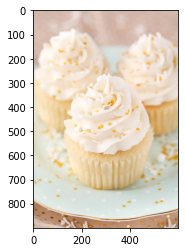

The prediction is:  cup_cakes 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0         0.00015  0.001134   0.755584   0.081965        0.021344   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.001057  0.004257  0.111965   0.000308  0.022237  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'cup_cake.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 2:  Downloaded Bibimbap Image [Link](http://www.chuonthis.ca/wp-content/uploads/2019/05/Bibimbap2-1.jpg)

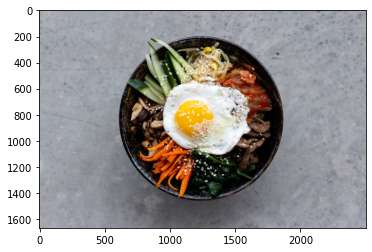

The prediction is:  bibimbap 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.011244  0.764348   0.000968   0.000391        0.011193   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.001237  0.015443  0.017634   0.003988  0.173554  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'bibimbap.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 3: Downloaded Pancakes Image [Link](https://bigoven-res.cloudinary.com/image/upload/t_recipe-1280/buttermilk-pancakes-65.jpg)

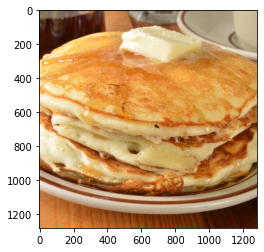

The prediction is:  pancakes 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.001675   0.00006   0.000682   0.025461        0.001802   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.068761  0.032243   0.83659   0.029682  0.003046  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'pancakes.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 4: Downloaded Prime Rib Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=VrnOms1p&id=BC6B09EE4C1A3045E23843146B58827B76E0EB31&thid=OIP.VrnOms1phd_t9q8ErrQ3LgHaE6&mediaurl=https%3a%2f%2fth.bing.com%2fth%2fid%2fR.56b9ce9acd6985dfedf6af04aeb4372e%3frik%3dMevgdnuCWGsUQw%26riu%3dhttp%253a%252f%252fouterbanksthisweek.com%252fsites%252fdefault%252ffiles%252fbusiness%252f2960%252ffood-items%252fprimerib.jpg%26ehk%3d4GV7JFn3L4LpH1B1oEuF84FRQNJZEtXDR0QfY9kVAFc%253d%26risl%3d%26pid%3dImgRaw%26r%3d0&exph=848&expw=1280&q=prime+rib&simid=608009421877835653&FORM=IRPRST&ck=995531F586504715053EBF6C004B9F26&selectedIndex=11&ajaxhist=0&ajaxserp=0)

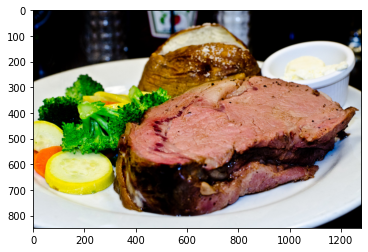

The prediction is:  prime_rib 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.013921  0.007372   0.000832   0.000156        0.000328   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.003757  0.011779  0.001544   0.960242  0.000069  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'prime_rib.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 5: Downloaded Tiramisu  Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=i1NCDjjJ&id=11D7CA78C1C3291CBCB1F53FF0311543B415AEA0&thid=OIP.i1NCDjjJdYV6mQyMKsjJ5QHaFv&mediaurl=https%3a%2f%2fpreview.redd.it%2f81k0b1zaurr31.jpg%3fauto%3dwebp%26s%3d4610d422e53f96ad574b71c25492ea7571f71e85&exph=2871&expw=3707&q=tiramisu&simid=608048926983139650&FORM=IRPRST&ck=759487F2119B60E8970FC53E8A31AF41&selectedIndex=0&ajaxhist=0&ajaxserp=0)

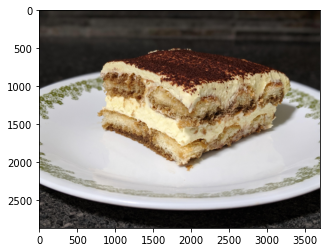

The prediction is:  tiramisu 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.000227  0.000039   0.000199   0.000598        0.007165   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.000644  0.009277  0.001134   0.000119  0.980598  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'tiramisu.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 6: Downloaded Lasagna Image [Link](https://thestayathomechef.com/wp-content/uploads/2018/07/Eggplant-Parmesan-2-1.jpg)

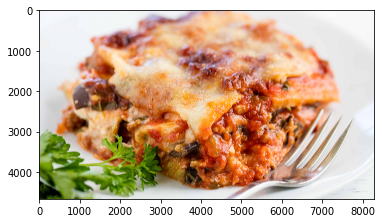

The prediction is:  lasagna 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.000455  0.010883   0.000149   0.000732        0.042326   

   garlic_bread  lasagna  pancakes  prime_rib  tiramisu  
0      0.007325  0.93162  0.005891   0.000335  0.000283  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'lasagna.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 7: Downloaded Garlic Bread Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=MfEsFMG1&id=3970EE8DED46CD6AEE4CCE45F7818287AA310C9C&thid=OIP.MfEsFMG1q8y8UmyqwD560gHaFj&mediaurl=https%3a%2f%2fsimply.delivery%2fwp-content%2fuploads%2f2018%2f03%2fWingKing-GarlicBread.jpg&exph=1440&expw=1920&q=garlic_bread&simid=608027190155701020&FORM=IRPRST&ck=25585E6F2F22E3AEEAD46626B7734AD8&selectedIndex=13&ajaxhist=0&ajaxserp=0)

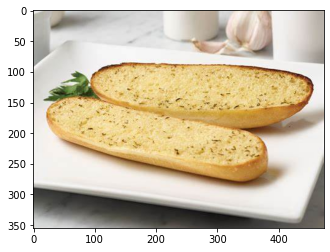

The prediction is:  garlic_bread 

    baby_back_ribs      bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.000754  5.030908e-07   0.000121   0.000047        0.000068   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.970334  0.000835  0.000627   0.025247  0.001967  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'garlic_bread.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 8: Downloaded Fried Calamari Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=LaqMubt8&id=32D5B6D4D5994FCB1E338A4168824D677C4B1E7D&thid=OIP.LaqMubt8iJh_DX0CeBxUeAHaGC&mediaurl=https%3a%2f%2fwww.greekboston.com%2fwp-content%2fuploads%2f2017%2f12%2fFried-Calamari.jpg&exph=2849&expw=3495&q=fried_calamari&simid=608043498146117084&FORM=IRPRST&ck=794547388D94E78ABB0D446C0E03C7DA&selectedIndex=0&ajaxhist=0&ajaxserp=0)

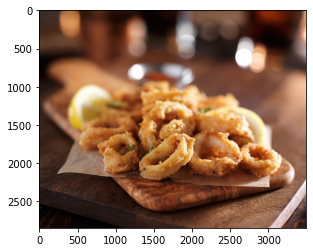

The prediction is:  fried_calamari 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.000445   0.00186   0.006415   0.001472         0.98428   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.000938  0.000235     0.004   0.000073  0.000282  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'fried_calamari.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 9: Downloaded Dumplings Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=aZJ6mhWR&id=60C296AF76389634B789AFADCC1D5DBA43AB4966&thid=OIP.aZJ6mhWR6KqWdUqx4c_ILwHaE8&mediaurl=https%3a%2f%2fcookingwithawallflower.com%2fwp-content%2fuploads%2f2020%2f03%2fGarlic-Chicken-Spinach-Dumplings-1.jpg&exph=864&expw=1296&q=dumplings&simid=608044254058592208&FORM=IRPRST&ck=7150D3A4B61BA6A114CA83AB9459922B&selectedIndex=9&ajaxhist=0&ajaxserp=0)

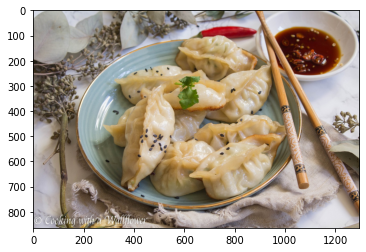

The prediction is:  dumplings 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.004822  0.042012   0.003075   0.517174        0.040879   

   garlic_bread   lasagna  pancakes  prime_rib  tiramisu  
0      0.037167  0.307633  0.005138    0.04091  0.001192  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'dumplings.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

### Prediction 10: Downloaded Baby Back Ribs  Image [Link](https://www.bing.com/images/search?view=detailV2&ccid=P5kfgoBv&id=725B5E4BEC985CF0DACDDF7F648AA15C77B78A6D&thid=OIP.P5kfgoBvHmBysEf975oYcwHaE8&mediaurl=https%3a%2f%2fwww.oklahomajoes.co.nz%2fImages%2fRecipes%2fMain%2fsmoked-baby-back-ribs.jpg&exph=1120&expw=1680&q=baby_back_ribs&simid=607999320112762110&FORM=IRPRST&ck=93C2D4E1485B31CA10A96519DDE46A83&selectedIndex=3&ajaxhist=0&ajaxserp=0)

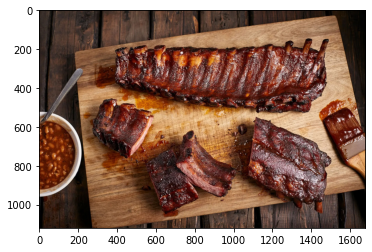

The prediction is:  baby_back_ribs 

    baby_back_ribs  bibimbap  cup_cakes  dumplings  fried_calamari  \
0        0.577099  0.000379   0.003305   0.002956        0.003274   

   garlic_bread  lasagna  pancakes  prime_rib  tiramisu  
0      0.324279  0.00309  0.069413   0.002037  0.014167  


In [ ]:
# Make prediction for the image you downloaded from internet

img = 'baby_back_ribs.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model5, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

# Thank You!